In [86]:
# model library
import tensorflow as tf

# image processing libraries
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# data processing libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# folder reading libraries
import glob
import os


## Loading in data

In [87]:
def gather_png_data(folder_path): # function to read in PNG image files
    files = glob.glob(folder_path + "/*.png")
    img_array = []
    for img in files:
        img = load_img(img, color_mode = "grayscale")
        img = img_to_array(img)  # convert PIL format to numpy array (note: 255 is white and 0 black)
        img_array.append(img)
    img_array = np.array(img_array)
    # map values to 0-1 such that 0 represents white, 1 represents black: better for model to process since white is not needed
    img_array = - (img_array/255) + 1
    return img_array

In [88]:
def listdir_non_hidden(folder_path): # function to only gather non-hidden folders
    folders = []
    for folder in os.listdir(folder_path):
        if not folder.startswith('.'):
            folders.append(folder)
    return folders

In [89]:
rel_folder_path = ("../data/training data/data (E,v,lambda)/Line Plots/") # folder path of training data relative to code, note: add "/" at end
categories = listdir_non_hidden(rel_folder_path)
data = []
class_names = []

# iterates through data folder and appends data into a list
for folders in categories:
    datas = gather_png_data(rel_folder_path + folders)
    data.append(datas)

# self-made labels for easy reference into the categories folder
for i in range(len(data)):
    class_names.append(i+1) # note: number in class_names corresponds to the number in category, not the index


In [90]:
# experimental data for testing
experimental_data = gather_png_data("../data/experimental data")

## Processing data

In [91]:
split_percent = 30 # represents the percentage of validation data for each category that will be taken out

train_labels = []
validation_labels = []
split_arr = []

for i in range(len(data)):
    # split data into training and validation sets
    x = round(data[i].shape[0] * split_percent/100)
    split = np.array_split(data[i],[0,x],axis=0) # array split returns 3 values of sub_arrays, 1 being a 0 dimension (useless)
    split_arr.append(split)
    
    # generate own labels for training purposes into train & validate group, i.e. each data[i] group is its own category
    for j in range(len(data[i])):
        if j<x:
            validation_labels.append(i)
        else:
            train_labels.append(i)
            
# convert labels to numpy array to input into model         
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

# create training & validating set by stacking along axis = 0
validation = []
train = []
for i in range(len(split_arr)):
    validation.append(split_arr[i][1])
    train.append(split_arr[i][2])

train_data = np.vstack(train)
validation_data = np.vstack(validation)


In [92]:
# to know what input shapes are being coded and to check for consistency
print(train_data.shape)
print(train_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)

x,y,z = train_data.shape[1],train_data.shape[2],train_data.shape[3]

(3696, 417, 417, 1)
(3696,)
(1587, 417, 417, 1)
(1587,)


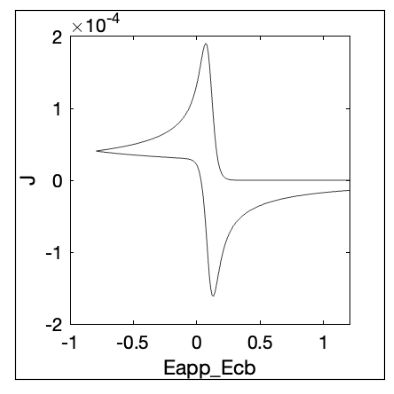

In [93]:
# for data exploration
plt.figure()
plt.imshow(train_data[y], cmap = "binary")
plt.xticks([])
plt.yticks([])
plt.show()

## Model building & training

In [94]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x,y,z)),
    tf.keras.layers.Dense(len(data)*8, activation='relu'),
    tf.keras.layers.Dense(len(data)*4, activation='relu'),
    tf.keras.layers.Dense(len(data))
])

In [95]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [96]:
model.fit(train_data, train_labels, epochs=5)

Epoch 1/5
116/116 [==============================] - 6s 48ms/step - loss: 0.3534 - accuracy: 0.9023
Epoch 2/5
116/116 [==============================] - 5s 47ms/step - loss: 0.0764 - accuracy: 0.9794
Epoch 3/5
116/116 [==============================] - 5s 47ms/step - loss: 0.0381 - accuracy: 0.9857
Epoch 4/5
116/116 [==============================] - 5s 47ms/step - loss: 0.0270 - accuracy: 0.9924
Epoch 5/5
116/116 [==============================] - 5s 46ms/step - loss: 0.0586 - accuracy: 0.9843


In [97]:
validate_loss, validate_acc = model.evaluate(validation_data,  validation_labels, verbose=2) #verbose is method of acknowledging program is running
print('\nValidation accuracy:', validate_acc)

50/50 - 1s - loss: 0.0489 - accuracy: 0.9861 - 507ms/epoch - 10ms/step

Validation accuracy: 0.9861373901367188


In [98]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()]) # softmax layer converts inputs to probabilities


In [99]:
predictions = probability_model.predict(validation_data)

50/50 [==============================] - 0s 8ms/step


In [100]:
exp_data = probability_model.predict(experimental_data) # test experimental data
exp_data

1/1 [==============================] - 0s 22ms/step


array([[1.0731527e-04, 1.9379576e-03, 5.5339322e-03, 3.1892717e-04,
        1.0030480e-03, 2.3736186e-02, 1.7960162e-03, 4.8524383e-04,
        1.6800064e-03, 2.1556953e-03, 8.8873409e-02, 2.1713276e-03,
        6.6697015e-03, 2.7162114e-01, 3.2563459e-02, 1.0821432e-01,
        4.4353801e-01, 7.5943135e-03]], dtype=float32)

## Presenting Data

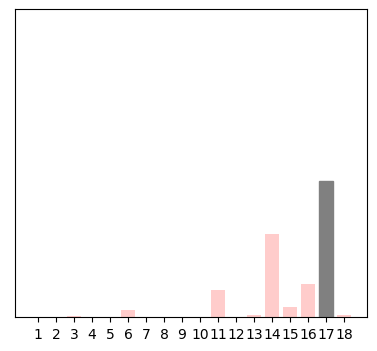

In [101]:
# for some experimental data
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.grid(False)
plt.xticks(range(len(data)),class_names)
plt.yticks([])
thisplot = plt.bar(range(len(data)), exp_data[0], color="#FFCCCB")
plt.ylim([0, 1])
predicted_label = np.argmax(exp_data)
thisplot[predicted_label].set_color('grey')
plt.show()

In [102]:
def plot_image(i, predictions_array, true_label, data): # function to plot line graph
    true_label, data = true_label[i], data[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data, cmap= "binary")

    predicted_label = np.argmax(predictions_array[i])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array[i]),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label): # function to plot bar chart 
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(len(data)),class_names)
    plt.yticks([])
    thisplot = plt.bar(range(len(data)), predictions_array[i], color="#FFCCCB")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[i])

    thisplot[predicted_label].set_color('red') 
    thisplot[true_label].set_color('blue') # if predicted label == true label, it appears blue due to overide

In [103]:
print("The number of validation data: ", len(validation_data)) 

The number of validation data:  1587


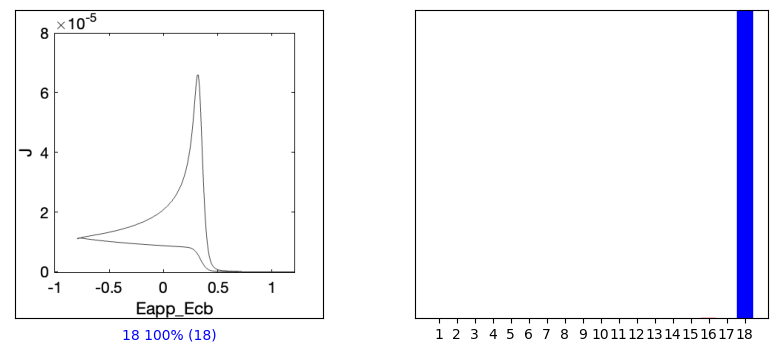

In [104]:
# to plot any single graph from the validation_data, check number above
i = 1586
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_image(i, predictions, validation_labels, validation_data)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  validation_labels)

plt.show()

In [105]:
# find all the wrong predictions in validation set
wrong_index = []
for i,labels in enumerate(validation_labels):
    predicted_label = np.argmax(predictions[i])
    if labels != predicted_label:
        wrong_index.append(i)
print(wrong_index)

[965, 977, 978, 996, 1055, 1071, 1148, 1194, 1233, 1236, 1244, 1251, 1257, 1307, 1325, 1338, 1341, 1350, 1414, 1428, 1446, 1505]


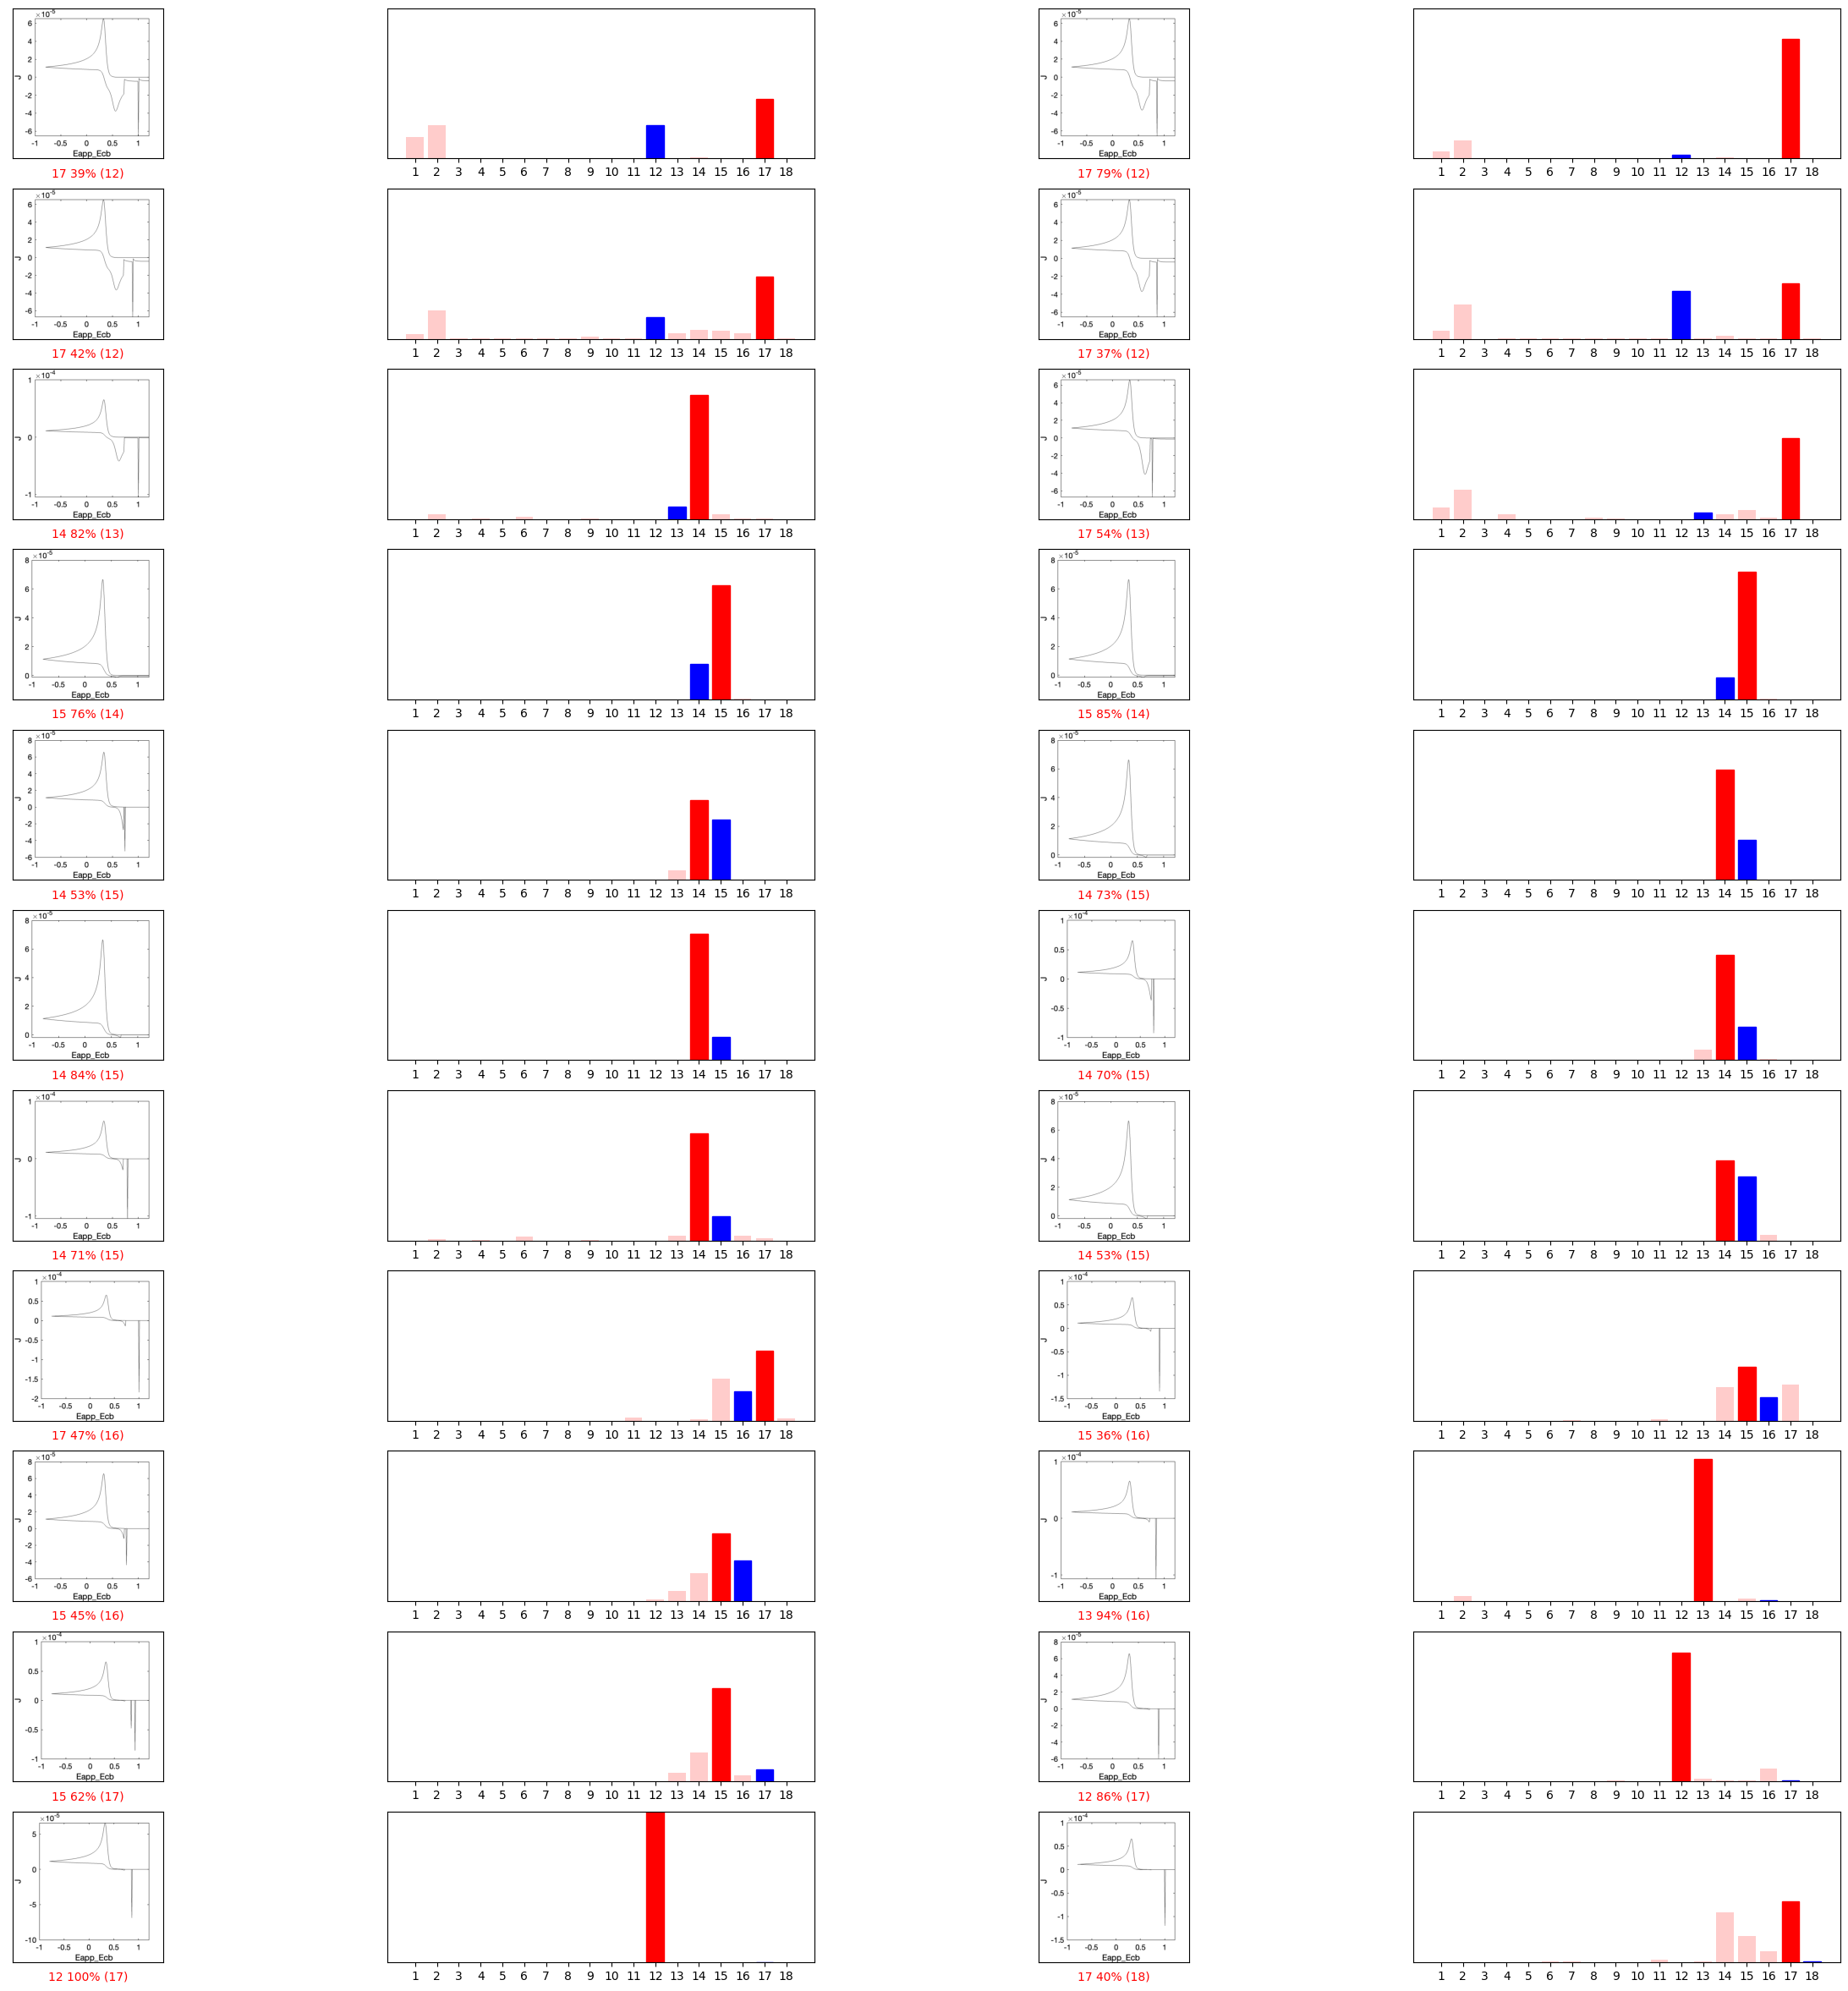

In [106]:
# collective results for wrong predictions in validation set
rows = math.ceil(len(wrong_index)/2)

plt.figure(figsize=(30,30))
for i,j in enumerate(wrong_index):
    plt.subplot(rows,4,2*i+1)
    plot_image(j,predictions,validation_labels,validation_data)
    plt.subplot(rows,4,2*i+2)
    plot_value_array(j,predictions,validation_labels)


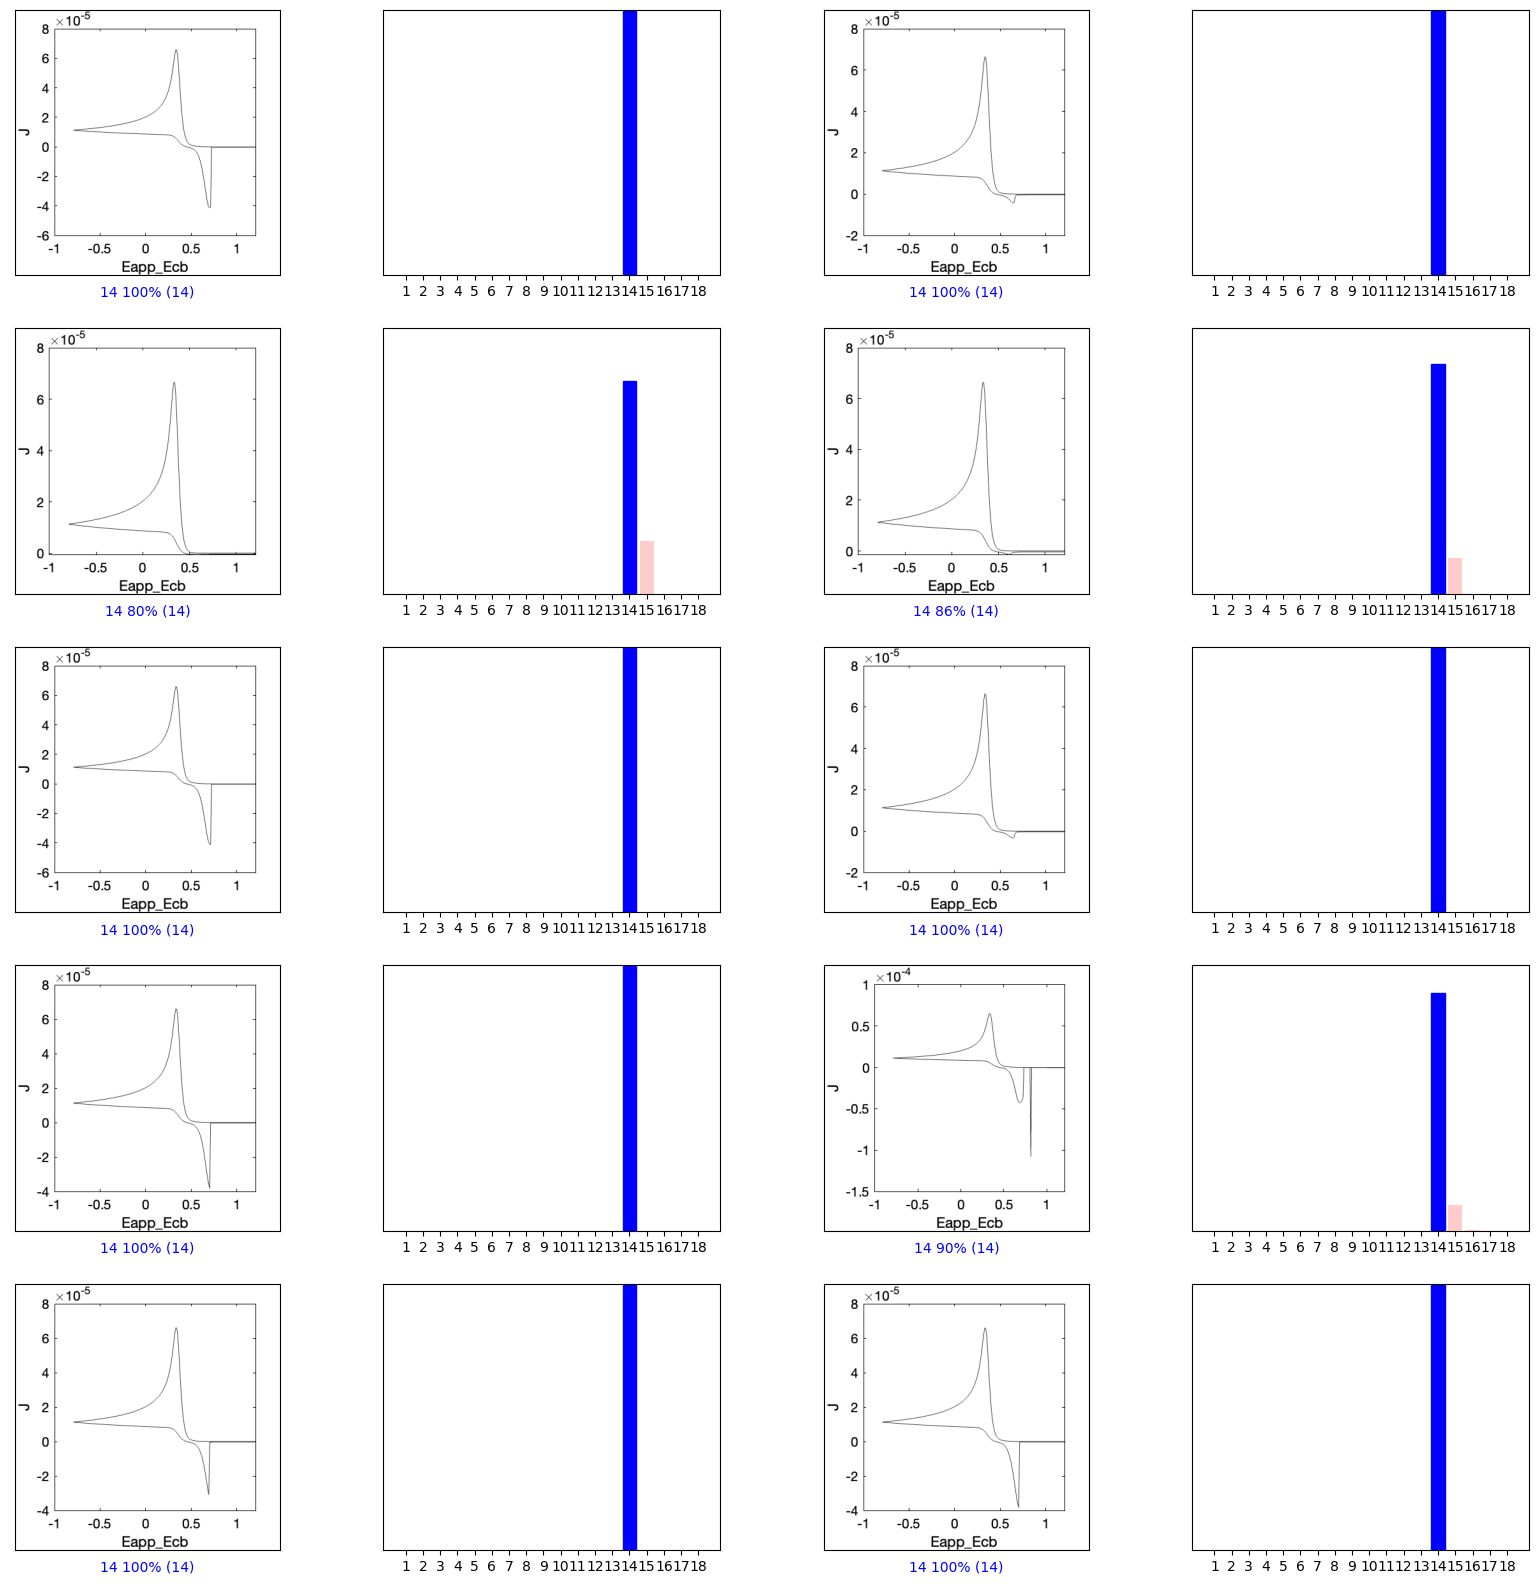

In [107]:
z = 1200

# some visualization for consecutive graphs
plt.figure(figsize=(20,20))
for i in range(z,z+10):
    plt.subplot(5,4,2*(i-z+1)-1)
    plot_image(i,predictions,validation_labels,validation_data)
    plt.subplot(5,4,2*(i-z+1))
    plot_value_array(i,predictions,validation_labels)

## Test/junk codes (used for initial referencing)

In [42]:
predicted_label = np.argmax(predictions[212])
print(predicted_label)
true_label = test_labels[212]
print(true_label)

2
2


In [24]:
test_data[600] # note 600 is out of bounds, value of a in test_data[a] is 0-(x*6)-1

IndexError: index 600 is out of bounds for axis 0 with size 600

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


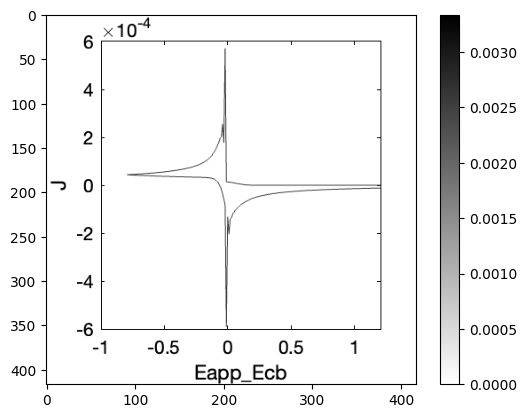

In [41]:
# how to present data as a black/white image
img = "C:/Users/Kit/Documents/PyCharm/venv/Image data/E=0,v=0.1,lambda=0.6 Line Plots/1.png"
img = load_img(img,color_mode = "grayscale")

img = img_to_array(img)
img = (img * (- 1/255)) + 1
print(img)
img = np.divide(img,255)

plt.imshow(img, cmap="binary")
plt.colorbar()

In [ ]:
# hard coded variant - used for initial testing - NOT NECESSARY NOW
# read in data into variables 
a = gather_png_data("../data/Image data/E=0,v=0.1,lambda=0.6 Line Plots")
b = gather_png_data("../data/Image data/E=0,v=1,lambda=0.6 Line Plots")
c = gather_png_data("../data/Image data/E=0.1,v=0.1,lambda=0.6 Line Plots")
d = gather_png_data("../data/Image data/E=0.1,v=1,lambda=0.6 Line Plots")
e = gather_png_data("../data/Image data/E=0.05,v=0.1,lambda=0.6 Line Plots")
f = gather_png_data("../data/Image data/E=0.05,v=1,lambda=0.6 Line Plots")

data = [a,b,c,d,e,f]
class_names = [1,2,3,4,5,6] # to rename into different categories

In [1]:
# running a test for git
for i in range(100):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
